In [1]:
import numpy as np

import cv2
from statistics import median_high
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, ZeroPadding2D,Activation, AveragePooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score

2025-04-30 03:23:30.136321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745983410.419552      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745983410.502502      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path_train = "/kaggle/input/brainmri/Datasest Merged 1/Datasest Merged 1"

In [3]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = {}
for i, classes in enumerate(class_names, start=0):
  class_labels[classes] = i

In [4]:
image_size = (130, 130)

In [5]:
#For Training data

train_data = []
train_labels = []

for folder in os.listdir(path_train):
    print("In folder: {}".format(folder))
    for file in os.listdir(os.path.join(path_train, folder)):
        image_path = os.path.join(path_train, folder, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, image_size)  # Resize the image using image_size
        train_data.append(image)
        train_labels.append(class_labels[folder])

train_data = np.array(train_data, dtype='float32')
train_labels = np.array(train_labels, dtype='int32')

train_data = train_data / 255.0 

In folder: pituitary
In folder: notumor
In folder: meningioma
In folder: glioma


In [6]:
train_data[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.01176471,
        0.00392157],
       ...,
       [0.00392157, 0.00784314, 0.00392157, ..., 0.00784314, 0.01176471,
        0.01176471],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

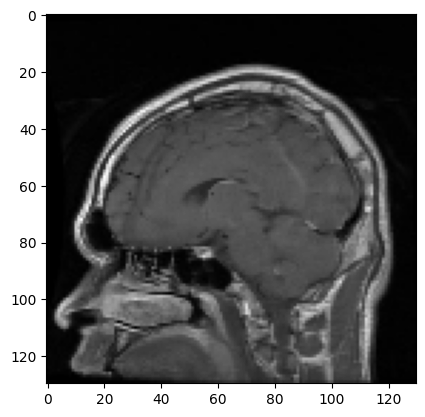

In [7]:
plt.imshow(train_data[0], cmap='gray')

In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels)
labels_encoded = to_categorical(labels_encoded)

# Print the mapping of labels to their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True)

# Convert to numpy arrays and reshape
X_train = np.array(X_train).reshape(-1, 130, 130, 1)
X_test = np.array(X_test).reshape(-1, 130, 130, 1)

# Define number of classes
num_classes = len(np.unique(train_labels))

print(num_classes)

4


In [10]:
# Resize images before converting to numpy arrays
X_train_resized = np.array([cv2.resize(img, (156, 156)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (156, 156)) for img in X_test])

# Reshape
X_train_resized = X_train_resized.reshape(-1, 156, 156, 1)
X_test_resized = X_test_resized.reshape(-1, 156, 156, 1)


In [11]:
import numpy as np
print("y_train classes:", np.unique(y_train))
print("y_test classes:", np.unique(y_test))

y_train classes: [0 1 2 3]
y_test classes: [0 1 2 3]


In [12]:
import keras
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=4)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=4)

# Verify the shape (should be (n_samples, 4) for both)
print("y_train_categorical shape:", y_train_categorical.shape)
print("y_test_categorical shape:", y_test_categorical.shape)

y_train_categorical shape: (9345, 4)
y_test_categorical shape: (4006, 4)


# VGG-19

In [28]:
import tensorflow as tf

input_shape = (130, 130, 1)  # Grayscale input
num_classes = 4

model_vgg19 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),

    # Block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 4
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Classification head
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [29]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history1 = model_vgg19.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3143 - loss: 1.3680
Epoch 1: val_accuracy improved from -inf to 0.36276, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 89s 320ms/step - accuracy: 0.3145 - loss: 1.3677 - val_accuracy: 0.3628 - val_loss: 1.4058
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5156 - loss: 1.0922
Epoch 2: val_accuracy improved from 0.36276 to 0.58052, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 69s 295ms/step - accuracy: 0.5156 - loss: 1.0921 - val_accuracy: 0.5805 - val_loss: 0.9830
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5820 - loss: 0.9695
Epoch 3: val_accuracy improved from 0.58052 to 0.63082, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 68s 292ms/step - accuracy: 0.5821 - loss: 0.9693 - val_accuracy: 0.6308 - val_loss: 0.8752
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.6466 - loss: 0.8386
Epoch 4: val_accuracy im

# VGG-19 With EfficientNet Capabilities

In [ ]:
import tensorflow as tf

input_shape = (156, 156, 1)  # Scaled resolution for grayscale input
num_classes = 4

model_vgg19_scaled = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),

    # Block 1: 2 Conv layers (original VGG19 count)
    tf.keras.layers.Conv2D(77, (3, 3), activation='relu', padding='same'),  # 64 * 1.2 = 77
    tf.keras.layers.Conv2D(77, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 2: 2 Conv layers (original VGG19 count)
    tf.keras.layers.Conv2D(154, (3, 3), activation='relu', padding='same'),  # 128 * 1.2 = 154
    tf.keras.layers.Conv2D(154, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 3: 4 Conv layers (original VGG19 count)
    tf.keras.layers.Conv2D(307, (3, 3), activation='relu', padding='same'),  # 256 * 1.2 = 307
    tf.keras.layers.Conv2D(307, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(307, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(307, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 4: 4 Conv layers (original VGG19 count)
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),  # 512 * 1.2 = 614
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 5: 4 Conv layers (original VGG19 count)
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),  # 512 * 1.2 = 614
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(614, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Classification head: 2 Dense layers (original VGG19 count)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4920, activation='relu'),  # 4096 * 1.2 = 4920
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4920, activation='relu'),  # 4096 * 1.2 = 4920
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [32]:
model_vgg19_scaled.compile(optimizer=Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Stop training if no improvement after 10 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history2 = model_vgg19_scaled.fit(X_train_resized, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2946 - loss: 1.3862   
Epoch 1: val_accuracy improved from -inf to 0.29856, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.2946 - loss: 1.3862 - val_accuracy: 0.2986 - val_loss: 1.3858
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.2907 - loss: 1.3854
Epoch 2: val_accuracy improved from 0.29856 to 0.40182, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.2908 - loss: 1.3854 - val_accuracy: 0.4018 - val_loss: 1.3694
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.4125 - loss: 1.2700
Epoch 3: val_accuracy improved from 0.40182 to 0.47405, saving model to best_model.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.4126 - loss: 1.2697 - val_accuracy: 0.4741 - val_loss: 1.1136
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.4617 - loss: 1.1299
Epoch 4: val_accuracy did not 

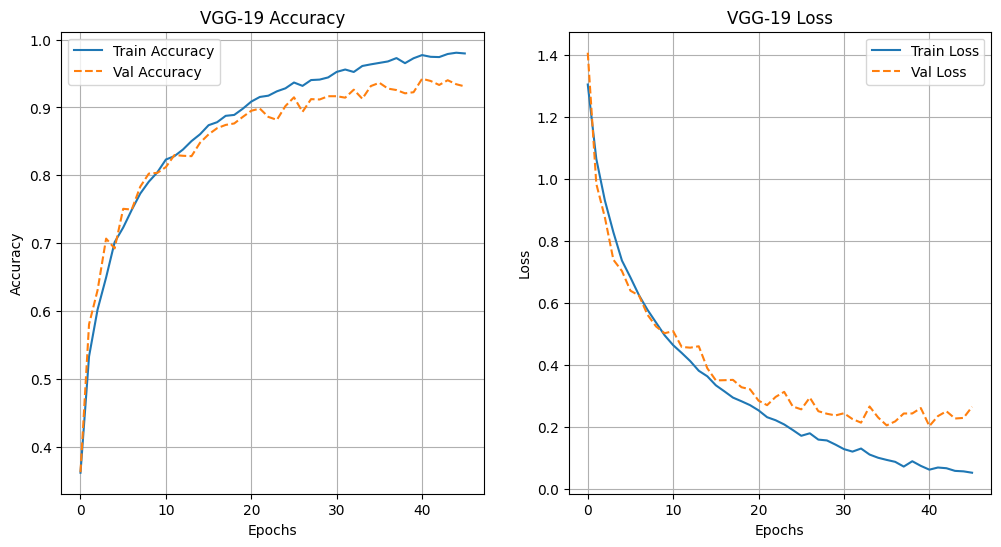

In [34]:
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('VGG-19 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('VGG-19 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

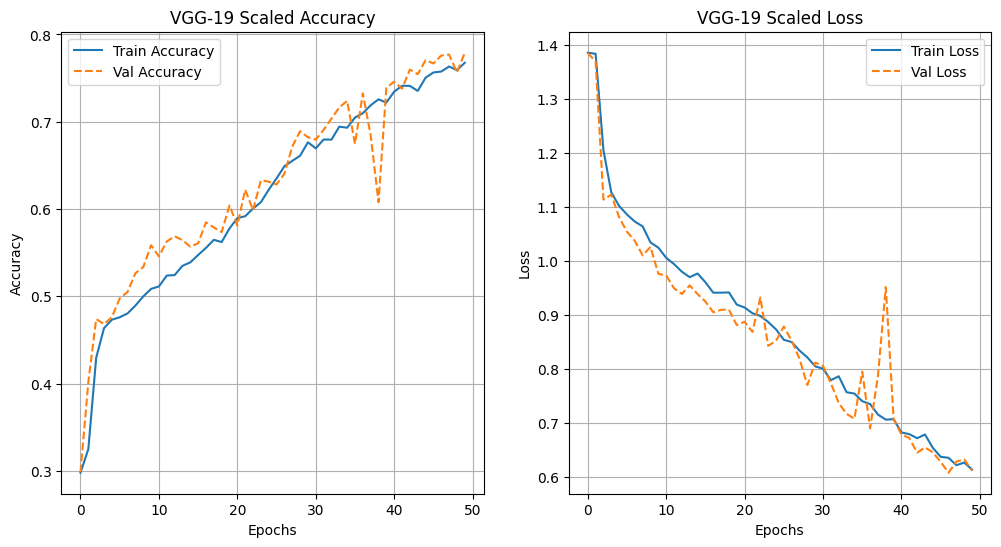

In [35]:
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('VGG-19 Scaled Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('VGG-19 Scaled Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Function to calculate specificity and sensitivity for multi-class
def specificity_score_multiclass(conf_matrix):
    specificity_per_class = []
    sensitivity_per_class = []
    
    for i in range(conf_matrix.shape[0]):  # Loop through each class
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
        tp = conf_matrix[i, i]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        specificity_per_class.append(specificity)
        sensitivity_per_class.append(sensitivity)
    
    return specificity_per_class, sensitivity_per_class

# Function to print model metrics and confusion matrix
def print_model_metrics(y_true, y_pred, model_name, class_names):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Compute specificity and sensitivity for each class
    specificity, sensitivity = specificity_score_multiclass(conf_matrix)
    
    # Print metrics
    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Specificity: {specificity[i]:.4f}, Sensitivity: {sensitivity[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Function to plot one image per class with predicted and true labels
def plot_sample_images_per_class(X, y_true, y_pred, class_names):
    plt.figure(figsize=(12, 8))
    
    shown_classes = set()
    class_indices = {}

    # Find one index per class
    for idx, label in enumerate(y_true):
        if label not in shown_classes:
            class_indices[label] = idx
            shown_classes.add(label)
        if len(shown_classes) == len(class_names):
            break

    for i, (label, idx) in enumerate(class_indices.items()):
        image = X[idx]
        if image.shape[-1] == 1:  # Grayscale
            image = image.squeeze()
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

    plt.suptitle("Sample Image Per Class with Prediction")
    plt.tight_layout()
    plt.show()

# Define your actual class names
class_names = ["Pituitary", "No Tumor", "Meningioma", "Glioma"]



126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step

Metrics for VGG-19:
Accuracy: 0.9383
Precision: 0.9382
Recall: 0.9383
F1 Score: 0.9382

Pituitary: Specificity: 0.9709, Sensitivity: 0.8995
No Tumor: Specificity: 0.9703, Sensitivity: 0.9173
Meningioma: Specificity: 0.9945, Sensitivity: 0.9866
Glioma: Specificity: 0.9804, Sensitivity: 0.9663


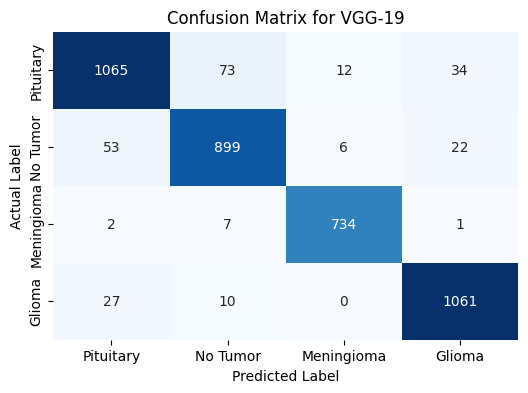


Classification Report:
              precision    recall  f1-score   support

   Pituitary       0.93      0.90      0.91      1184
    No Tumor       0.91      0.92      0.91       980
  Meningioma       0.98      0.99      0.98       744
      Glioma       0.95      0.97      0.96      1098

    accuracy                           0.94      4006
   macro avg       0.94      0.94      0.94      4006
weighted avg       0.94      0.94      0.94      4006



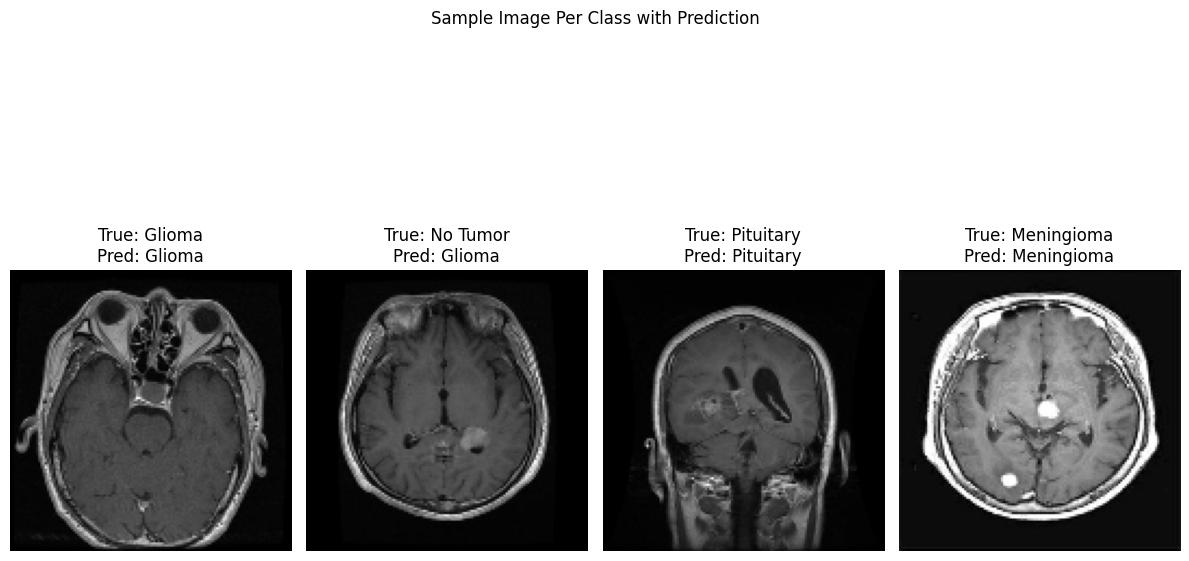

In [37]:
# Get predictions from your trained model
y_pred1 = np.argmax(model_vgg19.predict(X_test), axis=1)
y_true1 = y_test  # Assuming it's label-encoded already

# Show metrics and plots
print_model_metrics(y_true1, y_pred1, 'VGG-19', class_names)
plot_sample_images_per_class(X_test, y_true1, y_pred1, class_names)


126/126 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step

Metrics for VGG-19 Scaled:
Accuracy: 0.9468
Precision: 0.9470
Recall: 0.9468
F1 Score: 0.9469

Pituitary: Specificity: 0.9663, Sensitivity: 0.9341
No Tumor: Specificity: 0.9762, Sensitivity: 0.9265
Meningioma: Specificity: 0.9960, Sensitivity: 0.9825
Glioma: Specificity: 0.9887, Sensitivity: 0.9545


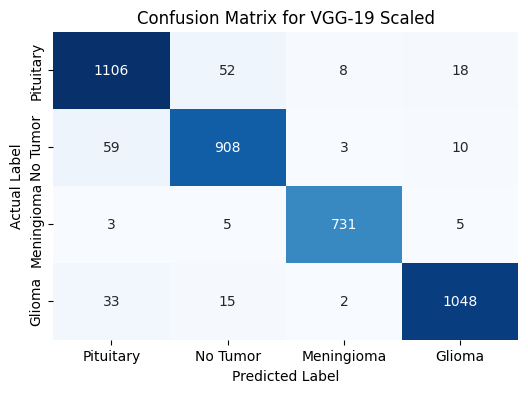


Classification Report:
              precision    recall  f1-score   support

   Pituitary       0.92      0.93      0.93      1184
    No Tumor       0.93      0.93      0.93       980
  Meningioma       0.98      0.98      0.98       744
      Glioma       0.97      0.95      0.96      1098

    accuracy                           0.95      4006
   macro avg       0.95      0.95      0.95      4006
weighted avg       0.95      0.95      0.95      4006



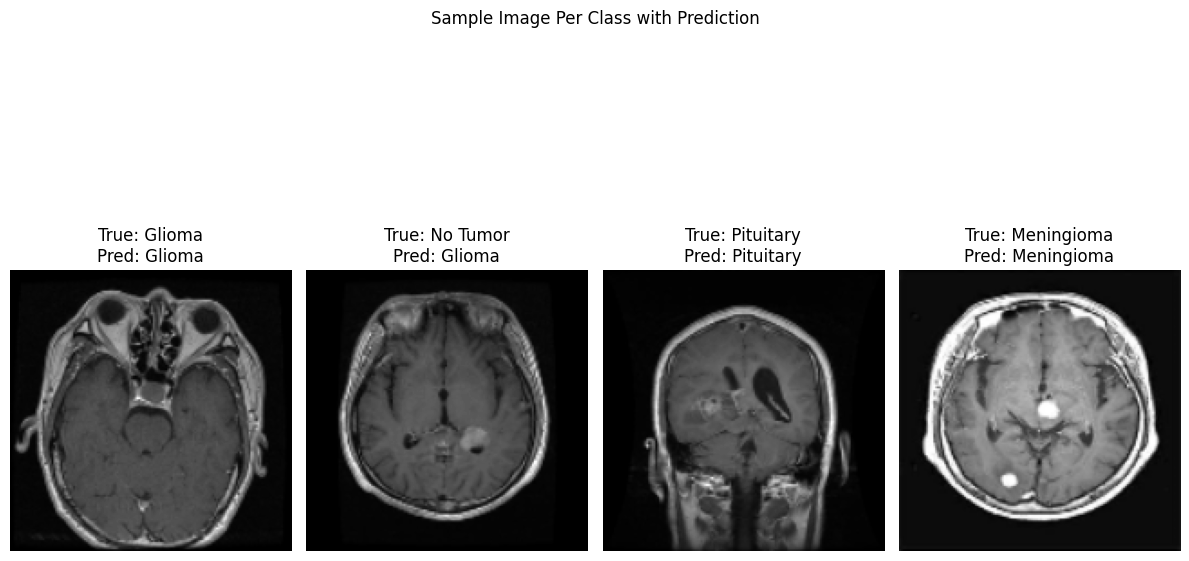

In [38]:
# Get predictions from your trainedmodel_vgg19_scaledmodel
y_pred1 = np.argmax(model_vgg16_scaled_dense.predict(X_test_resized), axis=1)
y_true1 = y_test  # Assuming it's label-encoded already

# Show metrics and plots
print_model_metrics(y_true1, y_pred1, 'VGG-19 Scaled', class_names)
plot_sample_images_per_class(X_test_resized, y_true1, y_pred1, class_names)
